# 1-D Canonical Non-Separable Example

Anthony Gruber 6-24-2023

In [39]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csc_matrix

import ROM_utils as ru
import OpInf_utils as ou
from KdV_BBM_utils import tridiag

# To suppress annoying umfpack "almost singular" warnings
import warnings
warnings.filterwarnings('ignore', '.*singular matrix!.*')

In [36]:
A = np.array([[0,1,1,1],[-1,0,1,1],[-1,-1,0,1],[-1,-1,-1,0]])
np.linalg.det(A)

1.0

## Define functions for generating data

In [40]:
# Define hamiltonian (depends on c)
def Hamil(x, dx):
    q, p  = np.split(x, 2, axis=0)
    return np.sum(q*p, axis=0) * dx

def IC(x, a):
    q, p  = np.split(x, 2, axis=0)
    return np.concatenate([np.sin(a*q)/np.exp(a*(q+1)), p], axis=0)
    # return np.concatenate([np.sin(a*q)+np.cos(2*a*q), p], axis=0)


# Function to assemble FOM operators
def assemble_FOM(Nover2, xEnds):
    xRange = np.linspace(xEnds[0], xEnds[1], Nover2)
    dx     = xRange[1] - xRange[0]

    # Build L
    zz     = np.zeros((Nover2, Nover2))
    ii     = np.eye(Nover2)
    L      = np.block([[zz, ii], [-ii, zz]])

    # Build A s.t. gradH(x) = Ax
    A         = np.block([[zz, ii], [ii, zz]])

    return L, A

## Generating training/testing data

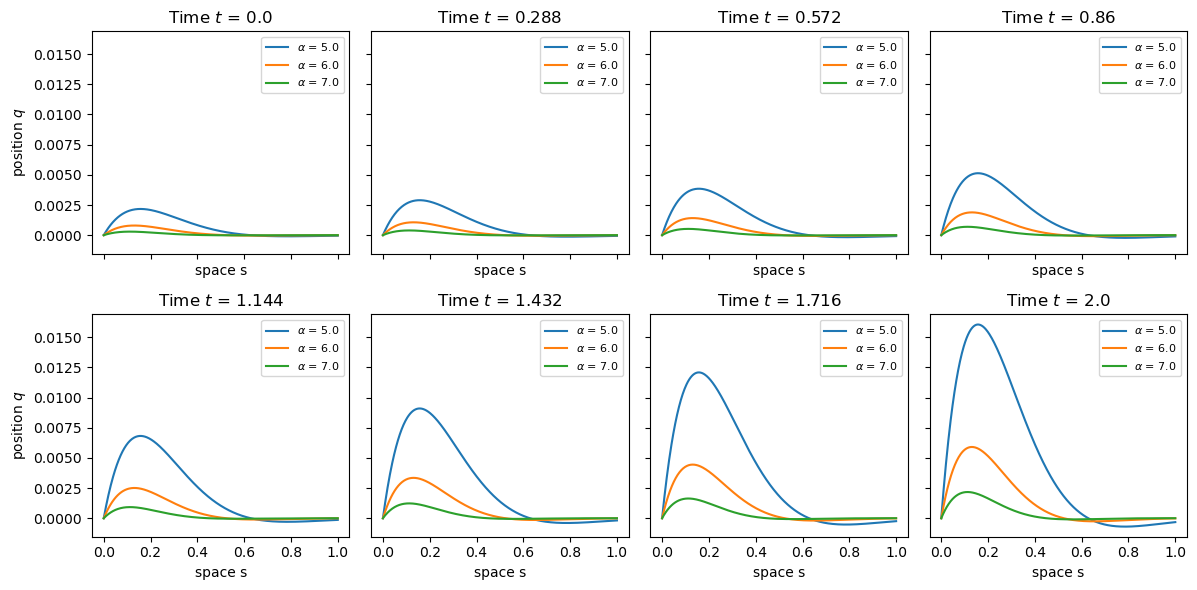

In [52]:
# Parameters for training
Nover2 = 500
Nt     = 501
T      = 2

# Ranges for training
xTrain = np.linspace(0, 1, Nover2)
tTrain = np.linspace(0, T, Nt)

# Generating ICs, 1-parameter family
npts = 11
aRange = np.linspace(5, 15, npts)
ICgrid = np.zeros((len(aRange), Nover2*2))

for i,a in enumerate(aRange):
    ICgrid[i] = IC(np.concatenate([xTrain, xTrain], axis=0), a)

# Assemble FOM and compute snapshots
L, A       = assemble_FOM(Nover2, [0,1])
X, Xd, gH  = ru.integrate_Linear_HFOM(tTrain, ICgrid[0], L, A)

# for mean centering
Xmc = X - ICgrid[0].reshape(-1,1)

for i,ic in enumerate(ICgrid[1:]):
    sol, soldot, grad = ru.integrate_Linear_HFOM(tTrain, ic, L, A)
    X  = np.concatenate((X,  sol),    axis=1)
    Xd = np.concatenate((Xd, soldot), axis=1)
    gH = np.concatenate((gH, grad),   axis=1)

    #for mean centering
    solmc = sol - ic.reshape(-1,1)
    Xmc   = np.concatenate((Xmc, solmc), axis=1)


name = "tab10"
cmap = plt.get_cmap(name)


fig, ax = plt.subplots(2, 4, figsize=(12,6), sharey=True, sharex=True)

ax.flatten()[0].set_ylabel(f'position $q$')
ax.flatten()[4].set_ylabel(f'position $q$')

# tList = [0, 50, 100, 150, 200, 250, 375, 500]
tList = [int(np.ceil(500/7*i)) for i in range(8)]
for k,t in enumerate(tList):
    ax.flatten()[k].plot(xTrain, X[:Nover2,t], label=r'$\alpha$ '+f'= {aRange[0]}', linestyle='-')
    ax.flatten()[k].plot(xTrain, X[:Nover2,t+501], label=r'$\alpha$ '+f'= {aRange[1]}', linestyle='-')
    ax.flatten()[k].plot(xTrain, X[:Nover2,t+1002], label=r'$\alpha$ '+f'= {aRange[2]}', linestyle='-')

    ax.flatten()[k].set_title(f'Time $t$ = {t/250}')
    ax.flatten()[k].set_xlabel(f'space s')

    ax.flatten()[k].legend(prop={'size':8})
plt.tight_layout()
plt.savefig(f'ParamCanonicalFOM', transparent=True)
plt.show()

## Nonparametric version

### Training the POD bases

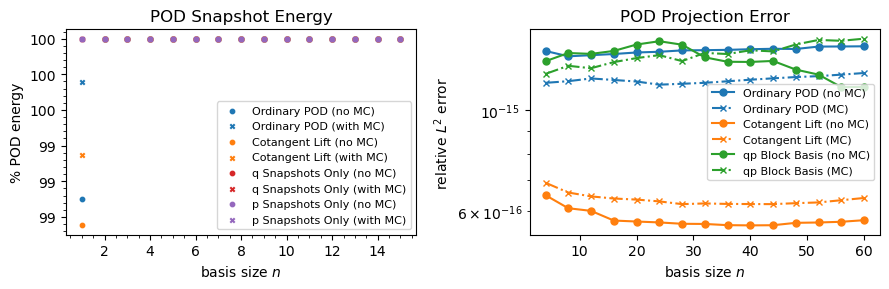

In [21]:
## Ordinary POD algo
UU, SS     = np.linalg.svd(X[:,:Nt])[:2]
UUmc, SSmc = np.linalg.svd(Xmc[:,:Nt])[:2]

### Cotangent lift algo:  U here is half the length of other one
Xlong        = np.concatenate((X[:Nover2,:Nt], X[Nover2:,:Nt]), axis=1)
Xmclong      = np.concatenate((Xmc[:Nover2,:Nt], Xmc[Nover2:,:Nt]), axis=1)
UU2, SS2     = np.linalg.svd(Xlong)[:2]
UU2mc, SS2mc = np.linalg.svd(Xmclong)[:2]

### Block q,p algo
UUq, SSq = np.linalg.svd(X[:Nover2,:Nt])[:2]
UUqmc, SSqmc = np.linalg.svd(Xmc[:Nover2,:Nt])[:2]
UUp, SSp = np.linalg.svd(X[Nover2:,:Nt])[:2]
UUpmc, SSpmc = np.linalg.svd(Xmc[Nover2:,:Nt])[:2]


nEigs = 15
idx = [i+1 for i in range(nEigs)]
X1 = X[:,:Nt]
ic = ICgrid[0].reshape(-1,1)

name = "tab10"
cmap = plt.get_cmap(name)

nList = [4*(i+1) for i in range(15)]
errU  = np.zeros(len(nList))
errUmc = np.zeros(len(nList))
errU2  = np.zeros(len(nList))
errU2mc = np.zeros(len(nList))
errUqp  = np.zeros(len(nList))
errUqpmc = np.zeros(len(nList))
for i,n in enumerate(nList):
    Umc   = UUmc[:,:n]
    U     = UU[:,:n]
    Ub    = UU2mc[:,:n//2]
    Zb    = np.zeros_like(Ub)
    U2mc = csc_matrix(np.block([[Ub, Zb], [Zb, Ub]]))
    Ub    = UU2[:,:n//2]
    Zb    = np.zeros_like(Ub)
    U2    = csc_matrix(np.block([[Ub, Zb], [Zb, Ub]]))
    Uq    = UUqmc[:,:n//2]
    Up    = UUpmc[:,:n//2]
    Zb    = np.zeros_like(Uq)
    Uqpmc = csc_matrix(np.block([[Uq, Zb], [Zb, Up]]))
    Uq    = UUq[:,:n//2]
    Up    = UUp[:,:n//2]
    Zb    = np.zeros_like(Uq)
    Uqp   = csc_matrix(np.block([[Uq, Zb], [Zb, Up]]))

    reconUmc   = ic.reshape(-1,1) + Umc @ Umc.T @ (X1 - ic.reshape(-1,1))
    reconU     = U @ U.T @ X1
    reconU2mc  = ic.reshape(-1,1) + U2mc @ U2mc.T @ (X1 - ic.reshape(-1,1))
    reconU2    = U2 @ U2.T @ X1
    reconUqpmc = ic.reshape(-1,1) + Uqpmc @ Uqpmc.T @ (X1 - ic.reshape(-1,1))
    reconUqp   = Uqp @ Uqp.T @ X1

    errUmc[i]   = ru.relError(X1, reconUmc)
    errU[i]     = ru.relError(X1, reconU)
    errU2mc[i]  = ru.relError(X1, reconU2mc)
    errU2[i]    = ru.relError(X1, reconU2)
    errUqpmc[i] = ru.relError(X1, reconUqpmc)
    errUqp[i]   = ru.relError(X1, reconUqp)

from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].set_title('POD Snapshot Energy')
ax[0].scatter(idx, np.cumsum(SS[:nEigs] / np.sum(SS))*100, s=10., label='Ordinary POD (no MC)', color=cmap.colors[0])
ax[0].scatter(idx, np.cumsum(SSmc[:nEigs] / np.sum(SSmc))*100, s=10., label='Ordinary POD (with MC)', marker='x', color=cmap.colors[0])
ax[0].scatter(idx, np.cumsum(SS2[:nEigs] / np.sum(SS2))*100, s=10., label='Cotangent Lift (no MC)', color=cmap.colors[1])
ax[0].scatter(idx, np.cumsum(SS2mc[:nEigs] / np.sum(SS2mc))*100, s=10., label='Cotangent Lift (with MC)', marker='x', color=cmap.colors[1])
ax[0].scatter(idx, np.cumsum(SSq[:nEigs] / np.sum(SSq))*100, s=10., label='q Snapshots Only (no MC)', color=cmap.colors[3])
ax[0].scatter(idx, np.cumsum(SSqmc[:nEigs] / np.sum(SSqmc))*100, s=10., label='q Snapshots Only (with MC)', marker='x', color=cmap.colors[3])
ax[0].scatter(idx, np.cumsum(SSp[:nEigs] / np.sum(SSp))*100, s=10., label='p Snapshots Only (no MC)', color=cmap.colors[4])
ax[0].scatter(idx, np.cumsum(SSpmc[:nEigs] / np.sum(SSpmc))*100, s=10., label='p Snapshots Only (with MC)', marker='x', color=cmap.colors[4])
ax[0].legend(prop={'size': 8})

ax[1].set_title('POD Projection Error')
ax[1].semilogy(nList, errU, label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errUmc, label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errU2, label='Cotangent Lift (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errU2mc, label='Cotangent Lift (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errUqp, label='qp Block Basis (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[2])
ax[1].semilogy(nList, errUqpmc, label='qp Block Basis (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[2])
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
ax[1].legend(prop={'size': 8})

# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
plt.tight_layout()
plt.savefig('CanonicalPODenergy', transparent=True)
plt.show()

## Parametric version

### Training the POD bases

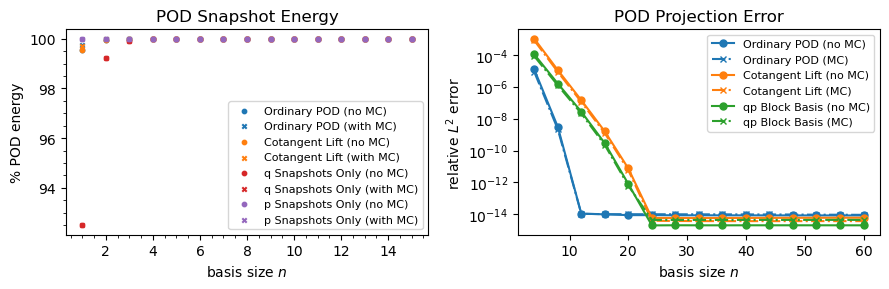

In [37]:
### Ordinary POD algo
UU, SS     = np.linalg.svd(X)[:2]
UUmc, SSmc = np.linalg.svd(Xmc)[:2]

### Symplectic lift algo:  U here is half the length of other one
Xlong   = np.concatenate((X[:Nover2],   X[Nover2:]),   axis=1)
Xmclong = np.concatenate((Xmc[:Nover2], Xmc[Nover2:]), axis=1)
UU2, SS2     = np.linalg.svd(Xlong)[:2]
UU2mc, SS2mc = np.linalg.svd(Xmclong)[:2]

### Block q,p algo
UUq, SSq = np.linalg.svd(X[:Nover2])[:2]
UUqmc, SSqmc = np.linalg.svd(Xmc[:Nover2])[:2]
UUp, SSp = np.linalg.svd(X[Nover2:])[:2]
UUpmc, SSpmc = np.linalg.svd(Xmc[Nover2:])[:2]


nEigs = 15
idx = [i+1 for i in range(nEigs)]
X1 = X.reshape(-1, npts, Nt)
X1 = X1.transpose((1,0,2))

name = "tab10"
cmap = plt.get_cmap(name)

nList   = [4*(i+1) for i in range(15)]
errU    = np.zeros((len(nList), npts))
errUmc  = np.zeros((len(nList), npts))
errU2   = np.zeros((len(nList), npts))
errU2mc = np.zeros((len(nList), npts))
errUqp  = np.zeros((len(nList), npts))
errUqpmc = np.zeros((len(nList), npts))
for i,n in enumerate(nList):
    Umc   = UUmc[:,:n]
    U     = UU[:,:n]
    Ub    = UU2mc[:,:n//2]
    Zb    = np.zeros_like(Ub)
    U2mc = csc_matrix(np.block([[Ub, Zb], [Zb, Ub]]))
    Ub    = UU2[:,:n//2]
    Zb    = np.zeros_like(Ub)
    U2    = csc_matrix(np.block([[Ub, Zb], [Zb, Ub]]))
    Uq    = UUqmc[:,:n//2]
    Up    = UUpmc[:,:n//2]
    Zb    = np.zeros_like(Uq)
    Uqpmc = csc_matrix(np.block([[Uq, Zb], [Zb, Up]]))
    Uq    = UUq[:,:n//2]
    Up    = UUp[:,:n//2]
    Zb    = np.zeros_like(Uq)
    Uqp   = csc_matrix(np.block([[Uq, Zb], [Zb, Up]]))

    for j, snaps in enumerate(X1):
        ic = ICgrid[j]

        reconUmc   = ic.reshape(-1,1) + Umc @ Umc.T @ (snaps - ic.reshape(-1,1))
        reconU     = U @ U.T @ snaps
        reconU2mc  = ic.reshape(-1,1) + U2mc @ U2mc.T @ (snaps - ic.reshape(-1,1))
        reconU2    = U2 @ U2.T @ snaps
        reconUqpmc = ic.reshape(-1,1) + Uqpmc @ Uqpmc.T @ (snaps - ic.reshape(-1,1))
        reconUqp   = Uqp @ Uqp.T @ snaps

        errUmc[i,j]   = ru.relError(snaps, reconUmc)
        errU[i,j]     = ru.relError(snaps, reconU)
        errU2mc[i,j]  = ru.relError(snaps, reconU2mc)
        errU2[i,j]    = ru.relError(snaps, reconU2)
        errUqpmc[i,j] = ru.relError(snaps, reconUqpmc)
        errUqp[i,j]   = ru.relError(snaps, reconUqp)

from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(1, 2, figsize=(9,3))

ax[0].set_title('POD Snapshot Energy')
ax[0].scatter(idx, np.cumsum(SS[:nEigs] / np.sum(SS))*100, s=10., label='Ordinary POD (no MC)', color=cmap.colors[0])
ax[0].scatter(idx, np.cumsum(SSmc[:nEigs] / np.sum(SSmc))*100, s=10., label='Ordinary POD (with MC)', marker='x', color=cmap.colors[0])
ax[0].scatter(idx, np.cumsum(SS2[:nEigs] / np.sum(SS2))*100, s=10., label='Cotangent Lift (no MC)', color=cmap.colors[1])
ax[0].scatter(idx, np.cumsum(SS2mc[:nEigs] / np.sum(SS2mc))*100, s=10., label='Cotangent Lift (with MC)', marker='x', color=cmap.colors[1])
ax[0].scatter(idx, np.cumsum(SSq[:nEigs] / np.sum(SSq))*100, s=10., label='q Snapshots Only (no MC)', color=cmap.colors[3])
ax[0].scatter(idx, np.cumsum(SSqmc[:nEigs] / np.sum(SSqmc))*100, s=10., label='q Snapshots Only (with MC)', marker='x', color=cmap.colors[3])
ax[0].scatter(idx, np.cumsum(SSp[:nEigs] / np.sum(SSp))*100, s=10., label='p Snapshots Only (no MC)', color=cmap.colors[4])
ax[0].scatter(idx, np.cumsum(SSpmc[:nEigs] / np.sum(SSpmc))*100, s=10., label='p Snapshots Only (with MC)', marker='x', color=cmap.colors[4])
ax[0].legend(prop={'size': 8})

ax[1].set_title('POD Projection Error')
ax[1].semilogy(nList, np.linalg.norm(errU, axis=1), label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, np.linalg.norm(errUmc, axis=1), label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, np.linalg.norm(errU2, axis=1), label='Cotangent Lift (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, np.linalg.norm(errU2mc, axis=1), label='Cotangent Lift (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, np.linalg.norm(errUqp, axis=1), label='qp Block Basis (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[2])
ax[1].semilogy(nList, np.linalg.norm(errUqpmc, axis=1), label='qp Block Basis (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[2])
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
ax[1].legend(prop={'size': 8})

# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
plt.tight_layout()
plt.savefig('CanonicalPODenergyParam', transparent=True)
plt.show()

### Testing the parametric version

First cell tests symplectic lift version, second tests standard version

In [42]:
# Generating Test Data
Ttest     = 10
NtTest    = 1001
tTest     = np.linspace(0, Ttest, NtTest)

nTestPts   = 6
aRangeTest = np.linspace(5.5, 14.5, nTestPts)
ICgridTest = np.zeros((len(aRangeTest), Nover2*2))

for i,a in enumerate(aRangeTest):
    ICgridTest[i] = IC(np.concatenate([xTrain, xTrain], axis=0), a)

Xtest, XdTest, gHtest  = ru.integrate_Linear_HFOM(tTest, ICgridTest[0], L, A)

for i,ic in enumerate(ICgridTest[1:]):
    sol, soldot, grad = ru.integrate_Linear_HFOM(tTest, ic, L, A)
    Xtest  = np.concatenate((Xtest,  sol),    axis=1)
    XdTest = np.concatenate((XdTest, soldot), axis=1)
    gHtest = np.concatenate((gHtest, grad),   axis=1)

Xac = Xtest.reshape(-1, nTestPts, NtTest)

print(f'train points are {aRange}')
print(f'test points are {aRangeTest}')

train points are [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
test points are [ 5.5  7.3  9.1 10.9 12.7 14.5]


/var/folders/fm/5nmtz1sx0qgfhs9hqsd70ycc00434g/T/ipykernel_33936/441654828.py:4: RuntimeWarning: overflow encountered in multiply
  return np.sum(q*p, axis=0) * dx


0 the relative L2 errors for intrusive GROM are [1.31798110e-01 6.49964468e-03 2.38948975e-04 1.28178059e-05
 1.16435894e-06 8.33455358e-08 8.33451741e-08 8.33451659e-08
 8.33444898e-08 8.33448484e-08 8.33443109e-08 8.33444004e-08
 8.33444936e-08 8.33443597e-08 8.33447763e-08]
0 the relative L2 errors for intrusive HROM are [2.43506575 1.33848145 0.61367279 0.42587791 0.41101563 0.41080584
 0.41110383 0.41135235 0.41137298 0.41147649 0.41161405 0.41163749
 0.41187883 0.41190507 0.41198329]
0 the relative L2 errors for generic OpInf are [1.28590519e-01 6.30777265e-03 2.28020493e-04 1.27092427e-05
 2.87034402e-06 5.28942438e+02 6.51296082e+13 7.00665235e+13
 1.02207951e+17 2.25690778e+51 3.63160102e+52 3.02359179e+52
 3.16460746e+65 1.99997511e+65 9.61719329e+66]
0 the relative L2 errors for noncanonical Hamiltonian OpInf are [1.77116924e-001 1.76349107e-001 1.76347969e-001 1.76347968e-001
 1.76347976e-001 2.55359506e+046 8.16260152e-002 1.14043738e+011
 1.17130159e+113 1.00000000e+000 1

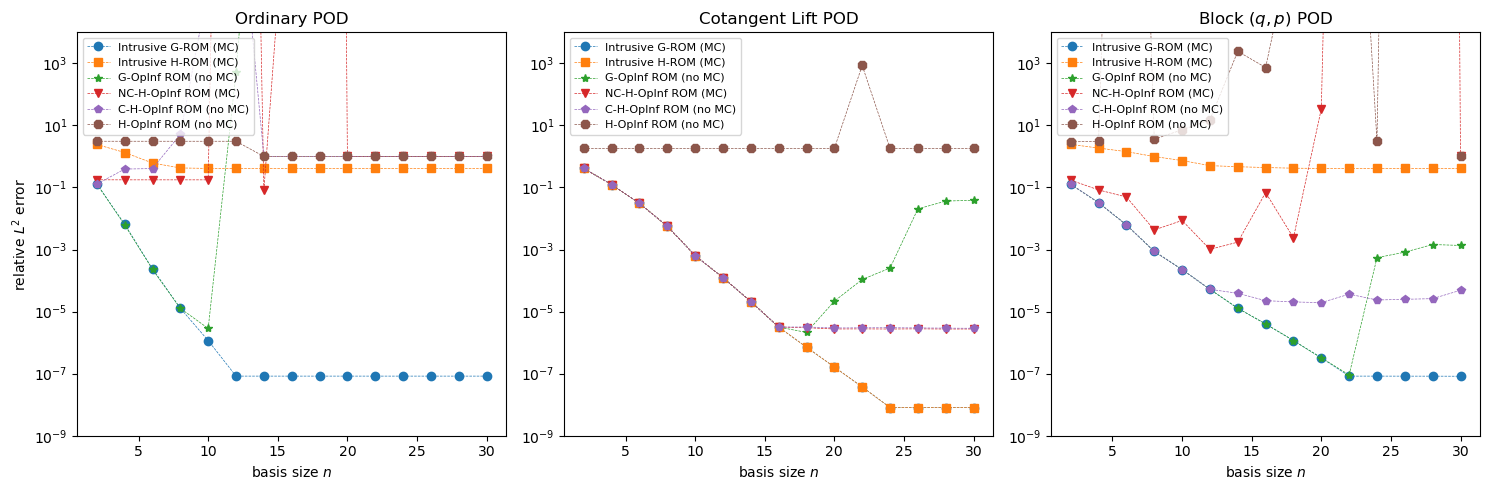

In [51]:
### Exact solution
dx  = xTrain[1]-xTrain[0]

### Parameters
# oneShotList = [True, True, True]
oneShotList = [False, False, False]
UmatList    = [UU, [UU2,UU2], [UUq,UUp]]
SigmaList   = [SS, None, None]
MCtog       = [True, True, True]
if any(MCtog):
    UmatListMC = [UUmc, [UU2mc, UU2mc], [UUqmc, UUpmc]]

nList = [2*(i+1) for i in range(15)]
eIntG  = np.zeros((3, nTestPts, len(nList)))
eIntH  = np.zeros((3, nTestPts, len(nList)))
eOpH   = np.zeros((3, nTestPts, len(nList)))
eOp    = np.zeros((3, nTestPts, len(nList)))
eOpA   = np.zeros((3, nTestPts, len(nList)))
eOpBZ  = np.zeros((3, nTestPts, len(nList)))


exactE     = np.zeros((nTestPts, NtTest))
HamileIntG = np.zeros((3, nTestPts, len(nList), NtTest))
HamileIntH = np.zeros((3, nTestPts, len(nList), NtTest))
HamileOpH  = np.zeros((3, nTestPts, len(nList), NtTest))
HamileOp   = np.zeros((3, nTestPts, len(nList), NtTest))
HamileOpA  = np.zeros((3, nTestPts, len(nList), NtTest))
HamileOpBZ = np.zeros((3, nTestPts, len(nList), NtTest))

XrecIntG = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecIntH = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecOp   = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecOpH  = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecOpA  = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecOpBZ = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_ylabel('relative $L^2$ error')

titleList   = ['Ordinary POD', 
               'Cotangent Lift POD',
               'Block $(q,p)$ POD']

alpha=1

for i in range(len(UmatList)):

    OpInfLists  = ou.build_OpInf_stuff(UmatList[i], X, Xd, 
                                        gH, L, nList[-1])
    
    if MCtog[i]:
        OpInfListMC = ou.build_OpInf_stuff(UmatListMC[i], X, Xd, 
                                           gH, L, nList[-1], MC=True)

    if oneShotList[i]:
        # Compute once and for all
        if MCtog[i]:
            LhatHOpFullMC = ou.NC_H_OpInf(OpInfListMC, nList[-1], eps=1.0e-16)
        else:
            LhatHOpFull   = ou.NC_H_OpInf(OpInfLists[0], nList[-1], eps=1.0e-16)
        
        AhatOpFull        = ou.C_H_OpInf(OpInfLists[1], nList[-1], SigmaList[i], approx=False, eps=1.0e-16)

    DhatOpFull            = ou.G_OpInf(OpInfLists[-1], nList[-1], SigmaList[i], eps=1.0e-16)


    for j,snaps in enumerate(Xac.transpose((1,0,2))):
        
        exactE[j] = Hamil(snaps, dx)
        ic = ICgridTest[j]

        OpLists     = ru.build_Linear_ROM_Ops(UmatList[i], L, A, ic, MC=False)
        OpListOL    = list(OpLists[0])

        if MCtog[i]:
            OpListsMC   = ru.build_Linear_ROM_Ops(UmatListMC[i], L, A, ic, MC=True)
            OpListMCOL  = list(OpListsMC[0])

        for k,n in enumerate(nList):

            if not oneShotList[i]:
                # Compute for each n
                DhatOp  = ou.G_OpInf(OpInfLists[-1], n, SigmaList[i], eps=1.0e-16)
                if MCtog[i]:
                    LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=1.0e-16)
                else:
                    LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=1.0e-16)
                
                AhatOp        = ou.C_H_OpInf(OpInfLists[1], n, SigmaList[i], eps=1.0e-16, BorisZhu=False, approx=False)
                AhatOpBZ      = ou.C_H_OpInf(OpInfLists[1], n, SigmaList[i], eps=0.0e-16, BorisZhu=True)

            else:
                if isinstance(UmatList[i], list):
                    Ablock1 = AhatOpFull[:n//2, :n//2]
                    idx = nList[-1]//2
                    Ablock2 = AhatOpFull[idx:idx+n//2,idx:idx+n//2]
                    AhatOp  = csc_matrix(np.block([[Ablock1, np.zeros((n//2,n//2))], 
                                                [np.zeros((n//2,n//2)), Ablock2]]))

                    Dblock1 = DhatOpFull[:n//2, :n//2]
                    idx = nList[-1]//2
                    Dblock2 = DhatOpFull[idx:idx+n//2,idx:idx+n//2]
                    DhatOp  = csc_matrix(np.block([[Dblock1, np.zeros((n//2,n//2))], 
                                                [np.zeros((n//2,n//2)), Dblock2]]))

                else:
                    DhatOp        = DhatOpFull[:n,:n]
                    AhatOp        = AhatOpFull[:n,:n]

                if MCtog[i]:
                    LhatHOpMC = LhatHOpFullMC[:n,:n]
                else:
                    LhatHOp   = LhatHOpFull[:n,:n]
        

            if MCtog[i]:
                OpListMCOL[0] = LhatHOpMC
                try:
                    XrecIntG[i,j,k] = ru.integrate_Linear_ROM(tTest, OpListsMC[1], ic, UmatListMC[i], n, MC=True)
                    XrecIntH[i,j,k] = ru.integrate_Linear_ROM(tTest, OpListsMC[0], ic, UmatListMC[i],
                                                        n, MC=True, Hamiltonian=True)
                    XrecOpH[i,j,k]  = ru.integrate_Linear_ROM(tTest, OpListMCOL, ic, UmatListMC[i],
                                                        n, MC=True, Hamiltonian=True)
                except ValueError:
                    pass
            else:
                OpListOL[0] = LhatHOp
                try:
                    XrecIntG[i,j,k] = ru.integrate_Linear_ROM(tTest, OpLists[1], ic, UmatList[i], n, MC=False)
                    XrecIntH[i,j,k] = ru.integrate_Linear_ROM(tTest, OpLists[0], ic, UmatList[i],
                                                        n, MC=False, Hamiltonian=True)
                    XrecOpH[i,j,k]  = ru.integrate_Linear_ROM(tTest, OpListOL, ic, UmatList[i],
                                                        n, MC=False, Hamiltonian=True)
                except ValueError:
                    pass
            try:
                XrecOp[i,j,k]   = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UmatList[i])
                XrecOpA[i,j,k]  = ru.integrate_OpInf_ROM(tTest, AhatOp, ic, UmatList[i], L)
                XrecOpBZ[i,j,k] = ru.integrate_OpInf_ROM(tTest, AhatOpBZ, ic, UmatList[i], L)
            except ValueError:
                pass

            eIntG[i,j,k] = ru.relError(snaps, XrecIntG[i,j,k])
            eIntH[i,j,k] = ru.relError(snaps, XrecIntH[i,j,k])
            eOp[i,j,k]   = ru.relError(snaps, XrecOp[i,j,k])
            eOpH[i,j,k]  = ru.relError(snaps, XrecOpH[i,j,k])
            eOpA[i,j,k]  = ru.relError(snaps, XrecOpA[i,j,k])
            eOpBZ[i,j,k] = ru.relError(snaps, XrecOpBZ[i,j,k])

            # HamileIntG[i,j,k] = np.abs(Hamil(XrecIntG[i,j,k], dx) - exactE)
            # HamileIntH[i,j,k] = np.abs(Hamil(XrecIntH[i,j,k], dx) - exactE)
            # HamileOp[i,j,k]   = np.abs(Hamil(XrecOp[i,j,k], dx) - exactE)
            # HamileOpH[i,j,k]  = np.abs(Hamil(XrecOpH[i,j,k], dx) - exactE)
            # HamileOpA[i,j,k]  = np.abs(Hamil(XrecOpA[i,j,k], dx) - exactE)
    
            HamileIntG[i,j,k] = Hamil(XrecIntG[i,j,k], dx)
            HamileIntH[i,j,k] = Hamil(XrecIntH[i,j,k], dx)
            HamileOp[i,j,k]   = Hamil(XrecOp[i,j,k], dx)
            HamileOpH[i,j,k]  = Hamil(XrecOpH[i,j,k], dx)
            HamileOpA[i,j,k]  = Hamil(XrecOpA[i,j,k], dx)
            HamileOpBZ[i,j,k]  = Hamil(XrecOpBZ[i,j,k], dx)

eIntGi = np.mean(eIntG, axis=1)
eIntHi = np.mean(eIntH, axis=1)
eOpi   = np.mean(eOp, axis=1)
eOpHi  = np.mean(eOpH, axis=1)
eOpAi  = np.mean(eOpA, axis=1)
eOpBZi  = np.mean(eOpBZ, axis=1)

for i in range(3):
    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntGi[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntHi[i]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOpi[i]}')
    print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpHi[i]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpAi[i]}')
    print(f'{i} the relative L2 errors for canonical Boris/Zhu OpInf are {eOpBZi[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntGi[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntHi[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpi[i],  label='G-OpInf ROM (no MC)', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpHi[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpAi[i], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    # if i==1:
    ax.flatten()[i].semilogy(nList, eOpBZi[i], label='H-OpInf ROM (no MC)', marker='8', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_ylim([10**-9, 10**4])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=2)
    ax.flatten()[i].set_xlabel('basis size $n$')

plt.tight_layout()
plt.savefig(f'CanonicalPlotParametricT{Ttest}', transparent=True)
plt.show()

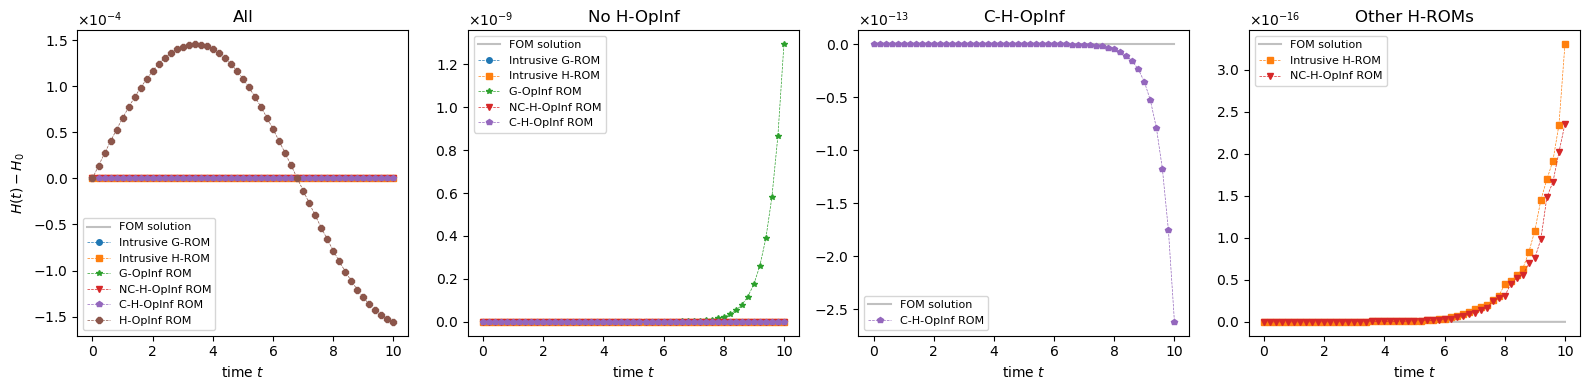

: 

In [53]:
name = "tab10"
cmap = plt.get_cmap(name)

plt.rcParams['axes.formatter.useoffset'] = True 

fig, ax = plt.subplots(1, 4, figsize=(16,4), sharex=True)
ax.flatten()[0].set_ylabel(r'$H(t) - H_0$')

skip=20
i,j,k = 1,1,4

titleList   = ['All', 
               'No H-OpInf',
               'C-H-OpInf' , 
               'Other H-ROMs']

ax.flatten()[0].plot(tTest[::skip], exactE[j][::skip]-exactE[j][0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[0].plot(tTest[::skip], HamileIntG[i,j,k][::skip]-HamileIntG[i,j,k][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileIntH[i,j,k][::skip]-HamileIntH[i,j,k][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOp[i,j,k][::skip]-HamileOp[i,j,k][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpH[i,j,k][::skip]-HamileOpH[i,j,k][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpA[i,j,k][::skip]-HamileOpA[i,j,k][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpBZ[i,j,k][::skip]-HamileOpBZ[i,j,k][0], label='H-OpInf ROM', color=cmap.colors[5], marker='8', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], exactE[j][::skip]-exactE[j][0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[1].plot(tTest[::skip], HamileIntG[i,j,k][::skip]-HamileIntG[i,j,k][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileIntH[i,j,k][::skip]-HamileIntH[i,j,k][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOp[i,j,k][::skip]-HamileOp[i,j,k][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpH[i,j,k][::skip]-HamileOpH[i,j,k][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpA[i,j,k][::skip]-HamileOpA[i,j,k][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], exactE[j][::skip]-exactE[j][::skip], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[2].plot(tTest[::skip], HamileOpA[i,j,k][::skip]-HamileOpA[i,j,k][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], exactE[j][::skip]-exactE[j][0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[3].plot(tTest[::skip], HamileIntH[i,j,k][::skip]-HamileIntH[i,j,k][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], HamileOpH[i,j,k][::skip]-HamileOpH[i,j,k][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[i].set_ylim([10**-5, 10**3.])
for i in range(4):
    ax.flatten()[i].set_title(f'{titleList[i]}', y=1.0)
    ax.flatten()[i].legend(prop={'size':8})
    ax.flatten()[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax.flatten()[i].set_xlabel('time $t$')
    # ax.flatten()[i].yaxis.set_major_formatter(y_formatter)
    # ax.flatten()[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2g'))
plt.tight_layout()
plt.savefig(f'Energy{2*(k+1)}modesCanonical', transparent=True)
plt.show()